In [310]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, re

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 80)
pd.set_option('display.max_rows', 100)

sys.path.append('/net/pulsar/home/koes/mtr22')
import param_search

expt_dir = '/net/pulsar/home/koes/mtr22/gan/torch_training'
os.chdir(expt_dir)
os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/net/pulsar/home/koes/mtr22/gan/torch_training'

In [448]:
molport_params = param_search.ParamSpace(
    data_root   ='/net/pulsar/home/koes/mtr22/molport',
    rec_molcache='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rec.molcache2',
    lig_molcache='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_lig.molcache2',
    train_file  ='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rand_train0.types',
    test_file   ='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rand_test0.types',
)

crossdock_params = param_search.ParamSpace(
    data_root   ='/net/pulsar/home/koes/paf46/Research/CrossDocking_script/PocketomeOutput/PocketomeGenCross_Output',
    rec_molcache='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/models/crossdock2020_rec.molcache2',
    lig_molcache='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/models/crossdock2020_lig.molcache2',
    train_file  ='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/types/it2_tt_0_train0.types',
    test_file   ='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/types/it2_tt_0_test0.types',
)

all_params = []
for random_seed in range(3):
    for model_type in ['GAN', 'VAEGAN', 'CGAN', 'CVAEGAN']: #['AE', 'VAE', 'CE', 'CVAE']:
        
        is_gan = model_type.endswith('GAN')
        is_vaegan = model_type.endswith('VAEGAN')
        is_cond = model_type.startswith('C')
        gan_loss_types = 'wx' if is_gan else '0'

        for gan_loss_type in gan_loss_types:
            is_wgan = (gan_loss_type == 'w')

            model_params = param_search.ParamSpace(
                
                random_seed=random_seed,
                caffe_init=False if is_wgan else True,
                do_continue=False,
                
                model_type=model_type,
                gan_loss_type=gan_loss_type,
                gan_loss_wt=1.0 if is_wgan else 10.0,
                optim_type='RMSprop' if is_wgan else 'Adam',
                
                n_gen_train_iters=1 if is_wgan else 2,
                gen_lr=0.0000001 if is_wgan else 0.00001,
                gen_grad_clip=100,
                gen_batch_norm=0,
                gen_spectral_norm=1 if is_wgan else 0,
                
                n_disc_train_iters=[2, 4, 8] if is_wgan else 2,
                disc_lr=0.00001 if is_wgan else 0.00001,
                disc_grad_clip=0 if is_wgan else 1.0,
                disc_batch_norm=0,
                disc_spectral_norm=1 if is_wgan else 0,

                disc_n_filters=32 if is_wgan else 16,
                disc_n_levels=4 if is_wgan else 3,
                disc_conv_per_level=3 if is_wgan else 1,
                
                extra_sbatch_line='#SBATCH -C M12' if is_vaegan else ''
            )
            
            if is_cond:
                model_params.update(crossdock_params)
            else:
                model_params.update(molport_params)
                
            all_params.append(model_params)

# NOTE dual encoder models require 12gb GPUs

sum(len(p) for p in all_params)

24

In [449]:
name_format = 'train_{model_type}_10_{n_disc_train_iters}_{gan_loss_type}_{random_seed}'

for template_file in ['train.config', 'train.sh']:

    job_files = param_search.setup(
        expt_dir=expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=sum(map(list, all_params), [])
    )

job_files

['/net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_10_2_w_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_10_2_x_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_2_w_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_2_x_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_CGAN_10_2_w_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_CGAN_10_2_x_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_CVAEGAN_10_2_w_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_CVAEGAN_10_2_x_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_10_2_w_1/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_GAN_10_2_x_1/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_2_w_1/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/torch_training/train_VAEGAN_10_2_x_1/train.sh',
 '/net/pulsar/home/koes/mtr22/

# Submit training jobs to cluster

In [450]:
job_ids = param_search.submit(job_files)
print(job_ids)

[6740993, 6740994, 6740995, 6740996, 6740997, 6740998, 6740999, 6741000, 6741001, 6741002, 6741003, 6741004, 6741005, 6741006, 6741007, 6741008, 6741009, 6741010, 6741011, 6741012, 6741013, 6741014, 6741015, 6741016]


In [477]:
df = pd.DataFrame(dict(
    group_name=[
        'non_gan', # non-GANs and WGANs, no atom fitting - the WGANs all diverged to nan, non-GAN still going strong
        'train_fitting', # try 3 random seeds, 3 latent sizes, GANs + WGANs, and atom fitting metrics - VAEGANs oom, GANs nan
        'train_fitting2', # use gen+disc gradient clipping, 64gb mem
        'train_fitting3', # fix missing module in atom_fitting.py
        'train_fitting4', # fix indent error in dkoes_fitting.py
        'train_fitting5', # fix zero divide and track memory usage
        'train_fitting6', # fix random seeds, n_latent, memory leak, try GANs with batchnorm + disc grad clip, WGANs with spectral norm, both with G/D ratios 1:2 or 1:4
        'train_fitting7', # try lower WGAN lr again, more disc iters, more gen iters for standard GAN
        'train_fitting8', # train_10 jobs: config files, diff G/D lrs, 100 grad clip, diff order
        'train_fitting9', # add scalar metrics, put job_params back in train.sh, use spectral norm instead of grad clip, default weight init, smaller repro discriminator
        'train_fitting10', # fix WGAN loss (was BCE), use repro solver/init GAN params, prior alternation
    ],
    job_id=[
        [6733823, 6733824, 6733825, 6733826],
        [6736277, 6736278, 6736279, 6736280, 6736281, 6736282, 6736283, 6736284, 6736285, 6736286, 6736287, 6736288, 6736289, 6736290, 6736291, 6736292, 6736293, 6736294, 6736295, 6736296, 6736297, 6736298, 6736299, 6736300, 6736301, 6736302, 6736303, 6736304, 6736305, 6736306, 6736307, 6736308, 6736309, 6736310, 6736311, 6736312, 6736313, 6736314, 6736315, 6736316, 6736317, 6736318, 6736319, 6736320, 6736321, 6736322, 6736323, 6736324, 6736325, 6736326, 6736327, 6736328, 6736329, 6736330, 6736331, 6736332, 6736333, 6736334, 6736335, 6736336, 6736337, 6736338, 6736339, 6736340, 6736341, 6736342, 6736343, 6736344, 6736345, 6736346, 6736347, 6736348],
        [6736473, 6736474, 6736475, 6736476, 6736477, 6736478, 6736479, 6736480, 6736481, 6736482, 6736483, 6736484, 6736485, 6736486, 6736487, 6736488, 6736489, 6736490, 6736491, 6736492, 6736493, 6736494, 6736495, 6736496, 6736497, 6736498, 6736499, 6736500, 6736501, 6736502, 6736503, 6736504, 6736505, 6736506, 6736507, 6736508, 6736509, 6736510, 6736511, 6736512, 6736513, 6736514, 6736515, 6736516, 6736517, 6736518, 6736519, 6736520, 6736521, 6736522, 6736523, 6736524, 6736525, 6736526, 6736527, 6736528, 6736529, 6736530, 6736531, 6736532, 6736533, 6736534, 6736535, 6736536, 6736537, 6736538, 6736539, 6736540, 6736541, 6736542, 6736543, 6736544],
        [6736546, 6736547, 6736548, 6736549, 6736550, 6736551, 6736552, 6736553, 6736554, 6736555, 6736556, 6736557, 6736558, 6736559, 6736560, 6736561, 6736562, 6736563, 6736564, 6736565, 6736566, 6736567, 6736568, 6736569, 6736570, 6736571, 6736572, 6736573, 6736574, 6736575, 6736576, 6736577, 6736578, 6736579, 6736580, 6736581, 6736582, 6736583, 6736584, 6736585, 6736586, 6736587, 6736588, 6736589, 6736590, 6736591, 6736592, 6736593, 6736594, 6736595, 6736596, 6736597, 6736598, 6736599, 6736600, 6736601, 6736602, 6736603, 6736604, 6736605, 6736606, 6736607, 6736608, 6736609, 6736610, 6736611, 6736612, 6736613, 6736614, 6736615, 6736616, 6736617],
        [6736618, 6736619, 6736620, 6736621, 6736622, 6736623, 6736624, 6736625, 6736626, 6736627, 6736628, 6736629, 6736630, 6736631, 6736632, 6736633, 6736634, 6736635, 6736636, 6736637, 6736638, 6736639, 6736640, 6736641, 6736642, 6736643, 6736644, 6736645, 6736646, 6736647, 6736648, 6736649, 6736650, 6736651, 6736652, 6736653, 6736654, 6736655, 6736656, 6736657, 6736658, 6736659, 6736660, 6736661, 6736662, 6736663, 6736664, 6736665, 6736666, 6736667, 6736668, 6736669, 6736670, 6736671, 6736672, 6736673, 6736674, 6736675, 6736676, 6736677, 6736678, 6736679, 6736680, 6736681, 6736682, 6736683, 6736684, 6736685, 6736686, 6736687, 6736688, 6736689],
        [6736802, 6736803, 6736804, 6736805, 6736806, 6736807, 6736808, 6736809, 6736810, 6736811, 6736812, 6736813, 6736814, 6736815, 6736816, 6736817, 6736818, 6736819, 6736820, 6736821, 6736822, 6736823, 6736824, 6736825, 6736826, 6736827, 6736828, 6736829, 6736830, 6736831, 6736832, 6736833, 6736834, 6736835, 6736836, 6736837, 6736838, 6736839, 6736840, 6736841, 6736842, 6736843, 6736844, 6736845, 6736846, 6736847, 6736848, 6736849, 6736850, 6736851, 6736852, 6736853, 6736854, 6736855, 6736856, 6736857, 6736858, 6736859, 6736860, 6736861, 6736862, 6736863, 6736864, 6736865, 6736866, 6736867, 6736868, 6736869, 6736870, 6736871, 6736872, 6736873],
        [6738318, 6738319, 6738320, 6738321, 6738322, 6738323, 6738324, 6738325, 6738326, 6738327, 6738328, 6738329, 6738330, 6738331, 6738332, 6738333, 6738334, 6738335, 6738336, 6738337, 6738338, 6738339, 6738340, 6738341, 6738342, 6738343, 6738344, 6738345, 6738346, 6738347, 6738348, 6738349, 6738350, 6738351, 6738352, 6738353, 6738354, 6738355, 6738356, 6738357, 6738358, 6738359, 6738360, 6738361, 6738362, 6738363, 6738364, 6738365],
        [6738460, 6738461, 6738462, 6738463, 6738464, 6738465, 6738466, 6738467, 6738468, 6738469, 6738470, 6738471, 6738472, 6738473, 6738474, 6738475, 6738476, 6738477, 6738478, 6738479, 6738480, 6738481, 6738482, 6738483, 6738484, 6738485, 6738486, 6738487, 6738488, 6738489, 6738490, 6738491, 6738492, 6738493, 6738494, 6738495, 6738496, 6738497, 6738498, 6738499, 6738500, 6738501, 6738502, 6738503, 6738504, 6738505, 6738506, 6738507],
        [6738804, 6738805, 6738806, 6738807, 6738808, 6738809, 6738810, 6738811, 6738812, 6738813, 6738814, 6738815, 6738816, 6738817, 6738818, 6738819, 6738820, 6738821, 6738822, 6738823, 6738824, 6738825, 6738826, 6738827, 6738828, 6738829, 6738830, 6738831, 6738832, 6738833, 6738834, 6738835, 6738836, 6738837, 6738838, 6738839, 6738840, 6738841, 6738842, 6738843, 6738844, 6738845, 6738846, 6738847, 6738848, 6738849, 6738850, 6738851],
        [6740080, 6740081, 6740082, 6740083, 6740084, 6740085, 6740086, 6740087, 6740088, 6740089, 6740090, 6740091, 6740092, 6740093, 6740094, 6740095, 6740096, 6740097, 6740098, 6740099, 6740100, 6740101, 6740102, 6740103, 6740104, 6740105, 6740106, 6740107, 6740108, 6740109, 6740110, 6740111, 6740112, 6740113, 6740114, 6740115, 6740116, 6740117, 6740118, 6740119, 6740120, 6740121, 6740122, 6740123, 6740124, 6740125, 6740126, 6740127],
        [6740993, 6740994, 6740995, 6740996, 6740997, 6740998, 6740999, 6741000, 6741001, 6741002, 6741003, 6741004, 6741005, 6741006, 6741007, 6741008, 6741009, 6741010, 6741011, 6741012, 6741013, 6741014, 6741015, 6741016]
    ]
)).explode('job_id')
df.groupby('group_name')['job_id'].agg(['count', 'min', 'max'])

,count,min,max
group_name,,,
non_gan,4,6733823,6733826
train_fitting,72,6736277,6736348
train_fitting10,24,6740993,6741016
train_fitting2,72,6736473,6736544
train_fitting3,72,6736546,6736617
train_fitting4,72,6736618,6736689
train_fitting5,72,6736802,6736873
train_fitting6,48,6738318,6738365
train_fitting7,48,6738460,6738507


In [478]:
import numpy as np
import glob, re
import param_search

qstat = param_search.status()
qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

df = df[df.group_name.isin(['non_gan', 'train_fitting10'])]
df = df.merge(qstat, on='job_id', how='left')

def find_work_dir(x):
    if 'work_dir' in x and not pd.isnull(x['work_dir']):
        return x['work_dir']
    f = glob.glob('*/{}.*'.format(x['job_id']))
    if f:
        return os.path.dirname(f[0])
    # else cancelled before running

def find_job_state(x):
    if 'job_state' in x and not pd.isnull(x['job_state']):
        return x['job_state']
    if x['work_dir'] is None:
        return 'CAN'
    if x['stderr'] is not None:
        return 'ERR'
    return 'OK'

def catch_exc(func, exc_type=Exception, default=None):
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except exc_type as e:
            return default
    return wrapper

df['work_dir'] = df.apply(find_work_dir, axis=1)
df['job_name'] = df['work_dir'].map(catch_exc(os.path.basename, TypeError))
df['job_file'] = df.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
df['stdout_file'] = df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
df['stderr_file'] = df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
df['stdout'] = df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError))
df['stderr'] = df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError))
df['job_state'] = df.apply(find_job_state, axis=1)

In [479]:
gen_grad_norm_re = re.compile(r'.*(gen_grad_norm=(\S+)).*')
def parse_stdout(x):
    return float(gen_grad_norm_re.match(x).group(2))

df['gen_grad_norm'] = df['stdout'].map(catch_exc(parse_stdout, (TypeError, AttributeError)))
df.set_index(['group_name', 'job_name', 'job_id'])[['job_state', 'stdout', 'stderr']]

job_state  \
group_name      job_name               job_id              
non_gan         train_AE_7             6733823         R   
                train_VAE_7            6733824         R   
                train_CE_7             6733825         R   
                train_CVAE_7           6733826         R   
train_fitting10 train_GAN_10_2_w_0     6740993         R   
                train_GAN_10_2_x_0     6740994       ERR   
                train_VAEGAN_10_2_w_0  6740995         R   
                train_VAEGAN_10_2_x_0  6740996       ERR   
                train_CGAN_10_2_w_0    6740997         R   
                train_CGAN_10_2_x_0    6740998       ERR   
                train_CVAEGAN_10_2_w_0 6740999       ERR   
                train_CVAEGAN_10_2_x_0 6741000       ERR   
                train_GAN_10_2_w_1     6741001         R   
                train_GAN_10_2_x_1     6741002       ERR   
                train_VAEGAN_10_2_w_1  6741003         R   
                train_VAEGAN_10_2_x_1  6741004        PD   
                train_CGAN_10_2_w_1    6741005         R   
                train_CGAN_10_2_x_1    6741006       ERR   
                train_CVAEGAN_10_2_w_1 6741007        PD   
                train_CVAEGAN_10_2_x_1 6741008        PD   
                train_GAN_10_2_w_2     6741009         R   
                train_GAN_10_2_x_2     6741010         R   
                train_VAEGAN_10_2_w_2  6741011        PD   
                train_VAEGAN_10_2_x_2  6741012        PD   
                train_CGAN_10_2_w_2    6741013        PD   
                train_CGAN_10_2_x_2    6741014        PD   
                train_CVAEGAN_10_2_w_2 6741015        PD   
                train_CVAEGAN_10_2_x_2 6741016        PD   

                                                                                                                                             stdout  \
group_name      job_name               job_id                                                                                                         
non_gan         train_AE_7             6733823  [iteration=791652 phase=train] loss=15.7035 recon_loss=15.7035 lig_norm=123.8379 lig_gen_norm=12...   
                train_VAE_7            6733824  [iteration=830312 phase=train] loss=46.4240 recon_loss=20.9921 kldiv_loss=254.3190 lig_norm=118....   
                train_CE_7             6733825  [iteration=747227 phase=train] loss=649.6559 recon_loss=649.6559 lig_norm=127.0012 lig_gen_norm=...   
                train_CVAE_7           6733826  [iteration=669557 phase=train] loss=77.6852 recon_loss=47.7694 kldiv_loss=299.1572 lig_norm=130....   
train_fitting10 train_GAN_10_2_w_0     6740993  [iteration=22692 disc_iter=45384 data_phase=train model_phase=disc grid_phase=real] loss=-480440...   
                train_GAN_10_2_x_0     6740994  [iteration=1129 disc_iter=1130 data_phase=train model_phase=gen grid_phase=prior] loss=0.0000 ga...   
                train_VAEGAN_10_2_w_0  6740995  [iteration=18314 disc_iter=36628 data_phase=train model_phase=disc grid_phase=real] loss=-113035...   
                train_VAEGAN_10_2_x_0  6740996  [iteration=7667 disc_iter=7668 data_phase=train model_phase=gen grid_phase=prior] loss=0.0000 ga...   
                train_CGAN_10_2_w_0    6740997  [iteration=22093 disc_iter=44186 data_phase=train model_phase=disc grid_phase=real] loss=-333284...   
                train_CGAN_10_2_x_0    6740998  [iteration=67 disc_iter=68 data_phase=train model_phase=gen grid_phase=prior] loss=0.0000 gan_lo...   
                train_CVAEGAN_10_2_w_0 6740999  [iteration=99 disc_iter=200 data_phase=train model_phase=gen grid_phase=prior] loss=-1.3137 gan_...   
                train_CVAEGAN_10_2_x_0 6741000  [iteration=6593 disc_iter=6594 data_phase=train model_phase=gen grid_phase=prior] loss=0.0000 ga...   
                train_GAN_10_2_w_1     6741001  [iteration=18225 disc_iter=36452 data_phase=train model_phase=gen grid_phase=prior] 

In [447]:
if input('Enter CANCEL to confirm: ') == 'CANCEL':
    param_search.cancel(' '.join(map(str, df[df.group_name == 'train_fitting10'].job_id)))

Enter CANCEL to confirm: CANCEL


# Read in training output metrics

/net/pulsar/home/koes/mtr22/gan/torch_training/train_CGAN_10_2_w_1/train.sh No columns to parse from file
/net/pulsar/home/koes/mtr22/param_search/results.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[group] = df[group_cols].apply(make_group_value, axis=1)


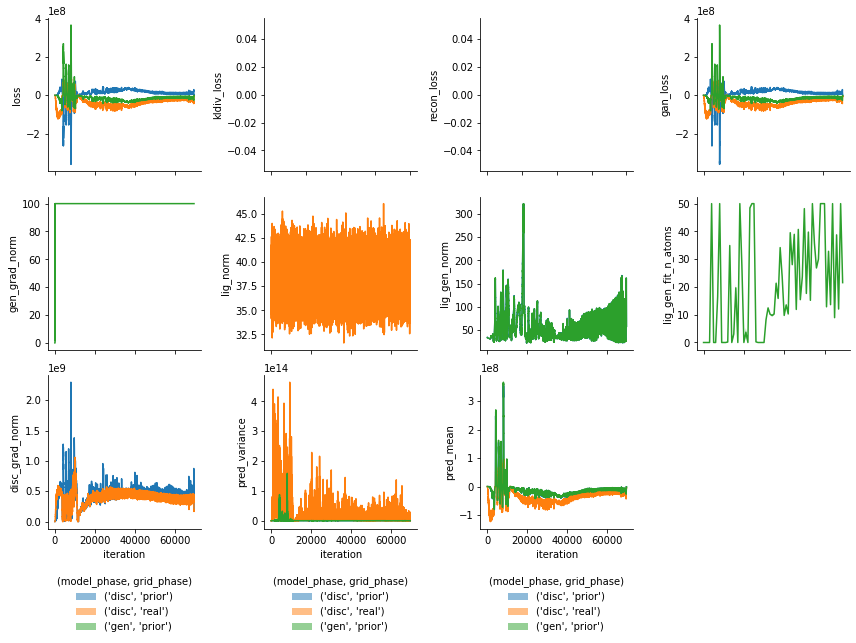

In [548]:
import numpy as np
import scipy.stats
import param_search

def safe_sem(x):
    return scipy.stats.sem(x) if len(x) > 1 else np.nan

def filled_lines(data, x, y, hue, ax, **kwargs):
    for h, hue_data in data.groupby(hue):
        hue_data = hue_data[~hue_data[y].isna()]
        try:
            mean = hue_data.groupby(x)[y].agg(np.nanmean)
            sem = hue_data.groupby(x)[y].agg(safe_sem)
            ax.fill_between(mean.index, mean - 2*sem, mean + 2*sem, alpha=0.5, label=h)
            ax.plot(mean.index, mean, label=h) #, marker='x')
        except Exception as e:
            print(e, hue_data[y].dtype, y)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
metrics = param_search.metrics(df[
    (df['group_name'] == 'train_fitting10')
].job_file, metric_pat='(.*)metrics')

n_examples = {
    '/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rand_train0.types':           97828036,
    '/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/types/it2_tt_0_train0.types': 14567805,
}

iter_bin_size = 100
#metrics['n_examples'] = metrics['train_file'].map(n_examples.get)
#metrics['epochs'] = metrics['iteration'] * metrics['batch_size'] / metrics['n_examples']
metrics['iter_bin'] = ((metrics['iteration'] // iter_bin_size) * iter_bin_size).astype(int)
metrics['total_iters'] = metrics['iteration'] + metrics['disc_iter'] 
metrics['loss_is_nan'] = metrics['loss'].isnull()
metrics['loss_is_zero'] = (metrics['loss'] == 0)
metrics['gen_grad_is_nan'] = metrics['gen_grad_norm'].isnull()
metrics['gen_grad_is_zero'] = (metrics['gen_grad_norm'] == 0)
metrics['disc_grad_is_zero'] = (metrics['disc_grad_norm'] == 0)
metrics['lig_gen_is_nan'] = metrics['lig_gen_norm'].isnull()

asdf = metrics.reset_index()

fig = param_search.plot(
    asdf[
        (asdf['job_name'] == 'train_GAN_10_2_w_0') &
        #(asdf['model_phase'] == 'disc') &
        #(asdf['data_phase'] == 'train') &
        #(asdf['iteration'] >= 20000) &
        #(asdf['iteration'] < 4000) &
        True
    ],
    x='iteration',
    y=[
        'loss', 'kldiv_loss', 'recon_loss', 'gan_loss',
        'gen_grad_norm', 'lig_norm', 'lig_gen_norm', 'lig_gen_fit_n_atoms', 
        'disc_grad_norm', 'pred_variance', 'pred_mean', #'lig_gen_fit_n_atoms',
    ],
    xlim=dict(),
    ylim=dict(),
    hue=('model_phase', 'grid_phase'),
    plot_func=filled_lines,
    n_cols=4, height=3
)

In [438]:
# WARNING: index_cols changed at train_fitting10, need to standardize to compare to previous groups e.g. non_gan
metrics['model_phase'] = metrics['model_phase'].fillna('gen')
metrics['grid_phase'] = metrics['grid_phase'].fillna('poster')

metrics[
    metrics['iteration'] == metrics.groupby('job_name')['iteration'].transform(max)
].groupby(['job_name', 'iteration', 'data_phase', 'model_phase', 'grid_phase'])[
    ['loss', 'gan_loss', 'gen_grad_norm', 'disc_grad_norm', 'lig_norm', 'lig_gen_norm']
].mean()

loss  \
job_name               iteration data_phase model_phase grid_phase                
train_CGAN_10_2_w_0    900       test       disc        prior         -0.994133   
                                                        real         -63.715823   
                                            gen         prior          1.091185   
train_CGAN_10_2_x_0    0         test       disc        prior          7.031383   
                                                        real           6.819483   
                                            gen         prior          6.820080   
train_CVAEGAN_10_2_w_0 3500      test       disc        poster      -175.655497   
                                                        prior       -191.352150   
                                                        real          62.430088   
                                            gen         poster      1324.024023   
                                                        prior        190.496561   
train_GAN_10_2_w_0     300       test       disc        prior         -0.023751   
                                                        real          -0.078191   
                                            gen         prior          0.023352   
train_GAN_10_2_x_0     100       test       disc        prior         68.150386   
                                                        real           6.753504   
                                            gen         prior          0.011056   
train_VAEGAN_10_2_w_0  200       test       disc        poster         0.005342   
                                                        prior          0.005342   
                                                        real          -0.006971   
                                            gen         poster       903.649902   
                                                        prior         -0.005342   
train_VAEGAN_10_2_x_0  500       test       disc        poster         7.869902   
                                                        prior         44.822357   
                                                        real           4.956253   
                                            gen         poster       628.574841   
                                                        prior          0.121845   

                                                                      gan_loss  \
job_name               iteration data_phase model_phase grid_phase               
train_CGAN_10_2_w_0    900       test       disc        prior        -0.994133   
                                                        real        -63.715823   
                                            gen         prior         1.091185   
train_CGAN_10_2_x_0    0         test       disc        prior         0.703138   
                                                        real          0.681948   
                                            gen         prior         0.682008   
train_CVAEGAN_10_2_w_0 3500      test       disc        poster     -175.655497   
                                                        prior      -191.352150   
                                                        real         62.430088   
                                            gen         poster      187.339883   
                                                        prior       190.496561   
train_GAN_10_2_w_0     300       test       disc        prior        -0.023751   
                                                        real         -0.078191   
                                            gen         prior         0.023352   
train_GAN_10_2_x_0     100       test       disc        prior         6.815039   
                                                        real          0.675350   
                                            gen         prior         0.001106   
train_VAEGAN_10_2_w_0  200       test       disc        poster        0.005342   
                           

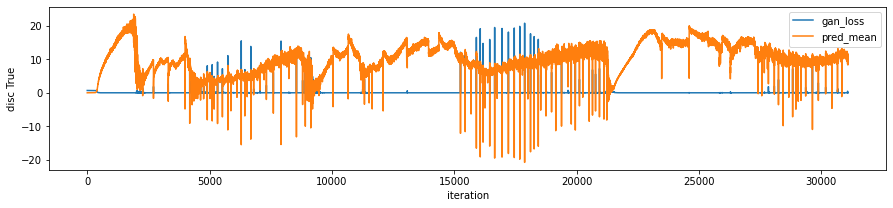

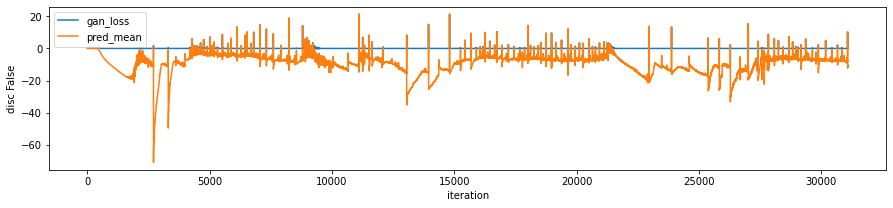

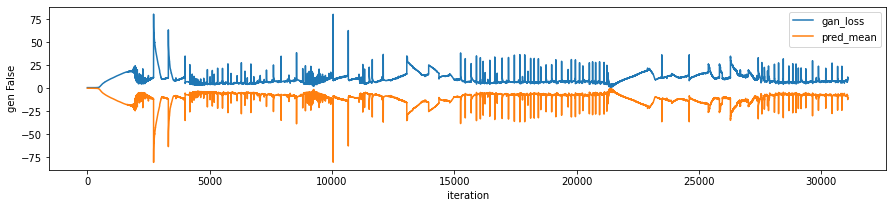

In [242]:
for model, real in [('disc', True), ('disc', False), ('gen', False)]:
    metrics[
        (metrics['job_name'] == 'train_VAGAN_10_2_w_0') &
        (metrics['phase'] == 'train') &
        (metrics['model'] == model) &
        (metrics['real'] == real) &
        True
    ].plot(x='iteration', y=['gan_loss', 'pred_mean'], figsize=(15, 3), ylabel='{} {}'.format(model, real))

In [248]:
metrics[
    (metrics['job_name'] == 'train_GAN_10_2_w_0') &
    (metrics['phase'] == 'train') &
    (metrics['iteration'] == 10000) &
    True
][['model', 'real', 'gan_loss', 'pred_mean', 'pred_variance']]

,model,real,gan_loss,pred_mean,pred_variance
32020,disc,True,0.000107,9.673417,1.275750
32021,disc,False,0.000036,-10.697939,0.851761
32022,gen,False,12.190516,-12.190511,0.364569


In [281]:
import torch

#labels, predictions = torch.ones(10, 1), torch.normal(9.673417, np.sqrt(1.275750), (10, 1))
#labels, predictions = torch.zeros(10, 1), torch.normal(-10.697939, np.sqrt(0.851761), (10, 1))
labels, predictions = torch.ones(10, 1), torch.normal(-12.190511, np.sqrt(0.364569), (10, 1))
assert labels.shape == predictions.shape

torch.nn.functional.binary_cross_entropy_with_logits(predictions, labels)

tensor(12.1767)

In [288]:
metrics.groupby('job_name')[['forward_gpu', 'backward_gpu']].max() / 1e3

,forward_gpu,backward_gpu
job_name,,
train_AE_7,NaN,NaN
train_CGAN_10_2_w_0,9.485360,5.971996
train_CGAN_10_2_x_0,9.060437,NaN
train_CGAN_10_4_w_0,9.484141,5.970027
train_CGAN_10_8_w_0,9.482360,5.967793
train_CVAEGAN_10_2_w_0,13.227198,8.648746
train_CVAE_7,NaN,NaN
train_GAN_10_2_w_0,4.892951,3.029729
train_GAN_10_2_w_1,5.017238,NaN


In [545]:
job = metrics[metrics.job_name == 'train_GAN_10_2_w_0']
job[job.iteration]